In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
import pickle

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

##Subida de los dfs

In [ ]:
train_labels = pd.read_csv('train_labels.csv')
train_labels

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3
...,...,...
260596,688636,2
260597,669485,3
260598,602512,3
260599,151409,2


In [ ]:
train_values = pd.read_csv('train_values.csv')
train_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260597,669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260598,602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260599,151409,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_tot = train_labels.merge(train_values, left_on='building_id', right_on='building_id').fillna(0)
df_tot

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,3,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,2,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,3,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,2,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,3,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,2,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260597,669485,3,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260598,602512,3,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
260599,151409,2,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_values = pd.read_csv('test_values.csv')
test_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0
86864,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
86865,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
86866,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
submission_format

,damage_grade
building_id,
300051,1
99355,1
890251,1
745817,1
421793,1
...,...
310028,1
663567,1
1049160,1


##Feature Engineering para el train_sample

###Interaccion entre features numericas

In [ ]:
df_tot['volume_percentage'] = df_tot.area_percentage * df_tot.height_percentage

In [ ]:
df_tot['floor_height'] = df_tot.height_percentage / df_tot.count_floors_pre_eq

In [ ]:
#Busco darle un peso a la edad del edificio y asi darle un puntaje entre 0 y 1
#Si la edad -> 0, el puntaje -> 1
#Si la edad -> inf, el puntaje -> 0
df_tot['age_area_relation'] = df_tot.area_percentage / (df_tot.age + df_tot.area_percentage.max())

In [ ]:
#Busco darle un peso a la edad del edificio y asi darle un puntaje entre 0 y 1
#Si la edad -> 0, el puntaje -> 1
#Si la edad -> inf, el puntaje -> 0
df_tot['age_height_relation'] = df_tot.height_percentage / (df_tot.age + df_tot.height_percentage.max())

In [ ]:
#Busco darle un peso a la edad del edificio y asi darle un puntaje entre 0 y 1
#Si la edad -> 0, el puntaje -> 1
#Si la edad -> inf, el puntaje -> 0
df_tot['age_volume_relation'] = df_tot.volume_percentage / (df_tot.age + df_tot.volume_percentage.max())

In [ ]:
#Las regiones (level 1) con mas de 6000 edificios con destrucción moderada o
# total registrados son: 6,17,10,8,7,21,26,20,4,27
ser_aux =(df_tot.geo_level_1_id == 6)|(df_tot.geo_level_1_id == 17)|(df_tot.geo_level_1_id == 10)\
          |(df_tot.geo_level_1_id == 8)|(df_tot.geo_level_1_id == 7)|(df_tot.geo_level_1_id == 21)\
          |(df_tot.geo_level_1_id == 26)|(df_tot.geo_level_1_id == 20)|(df_tot.geo_level_1_id == 4)\
          |(df_tot.geo_level_1_id == 27)
df_tot['is_from_most_affected_regions'] = ser_aux.replace({True: 1, False: 0})

In [ ]:
#Los rubros mas afectados son: agriculture,hotel,rental,institution
ser_aux2 = (df_tot.has_secondary_use_agriculture==1)|(df_tot.has_secondary_use_hotel==1)|\
            (df_tot.has_secondary_use_rental==1)|(df_tot.has_secondary_use_institution==1)
df_tot['is_from_most_affected_usages'] = ser_aux2.replace({True: 1, False: 0})

In [ ]:
df_tot['count_fams_per_area'] = df_tot.count_families / df_tot.area_percentage

In [ ]:
df_tot['count_fams_per_height'] = df_tot.count_families / df_tot.height_percentage

In [ ]:
df_tot['count_fams_per_volume'] = df_tot.count_families / df_tot.volume_percentage

In [ ]:
df_tot['count_materials_used'] = df_tot.has_superstructure_adobe_mud+df_tot.has_superstructure_bamboo+\
                                  df_tot.has_superstructure_cement_mortar_brick+df_tot.has_superstructure_cement_mortar_stone+\
                                  df_tot.has_superstructure_mud_mortar_brick+df_tot.has_superstructure_mud_mortar_stone+\
                                  df_tot.has_superstructure_other+df_tot.has_superstructure_rc_engineered+\
                                  df_tot.has_superstructure_rc_non_engineered+df_tot.has_superstructure_stone_flag+\
                                  df_tot.has_superstructure_timber\


In [ ]:
df_tot

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used
0,802906,3,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.046154,0.080645,0.011407,1,0,0.166667,0.200000,0.033333,2
1,28830,2,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,56,3.500000,0.072727,0.166667,0.021456,1,0,0.125000,0.142857,0.017857,1
2,94947,3,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,25,2.500000,0.045455,0.119048,0.009579,1,0,0.200000,0.200000,0.040000,1
3,590882,2,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.054545,0.119048,0.011494,0,0,0.166667,0.200000,0.033333,3
4,201944,3,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,72,3.000000,0.061538,0.145161,0.027376,0,0,0.125000,0.111111,0.013889,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,2,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,18,3.000000,0.038710,0.034483,0.006780,0,0,0.166667,0.333333,0.055556,1
260597,669485,3,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.060000,0.156250,0.011538,1,0,0.166667,0.200000,0.033333,1
260598,602512,3,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.038710,0.080460,0.015819,1,0,0.166667,0.142857,0.023810,1
260599,151409,2,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,84,3.000000,0.127273,0.142857,0.032184,1,0,0.071429,0.166667,0.011905,1


###Features con KNN

In [ ]:
def find_k(X, y, a, b):
  k_range = range(a, b)
  scores = []
  for k in k_range:
      knn = KNeighborsClassifier(n_neighbors = k, metric='manhattan')
      knn.fit(X, y)
      scores.append(knn.score(X, y))
  plt.figure()
  plt.xlabel('k')
  plt.ylabel('accuracy')
  plt.scatter(k_range, scores)
  plt.xticks([0 if a == 1 else a,a+4 if a == 1 else a+5,a+9 if a == 1 else a+10,
              a+14 if a == 1 else a+15,a+19if a == 1 else a+20])
  return 

####Features con geo_level

In [ ]:
predictors = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
outcome = 'damage_grade'
X = df_tot[predictors]
y = df_tot[outcome]

Probamos distintos valores de k para ver cual es el que mayor presición logra

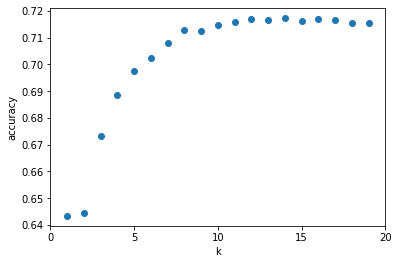

In [ ]:
find_k(X, y, 1, 20)

En el gráfico se observa como k = 14 es el valor que mejor presición tiene, por lo tanto usamos esa cantidad de n_neighbors

In [ ]:
#KNN as a feature engineering
knn_1 = KNeighborsClassifier(n_neighbors= 14, metric='manhattan')
knn_1.fit(X, y)
predic = pd.DataFrame(data = knn_1.predict_proba(X))
predic.columns = ['1_damage_probability', '2_damage_probability', '3_damage_probability']
df_tot['3_damage_probability_with_glb'] = predic['3_damage_probability'] 
df_tot

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used,3_damage_probability_with_glb
0,802906,3,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.046154,0.080645,0.011407,1,0,0.166667,0.200000,0.033333,2,0.857143
1,28830,2,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,56,3.500000,0.072727,0.166667,0.021456,1,0,0.125000,0.142857,0.017857,1,0.142857
2,94947,3,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,25,2.500000,0.045455,0.119048,0.009579,1,0,0.200000,0.200000,0.040000,1,0.857143
3,590882,2,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.054545,0.119048,0.011494,0,0,0.166667,0.200000,0.033333,3,0.214286
4,201944,3,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,72,3.000000,0.061538,0.145161,0.027376,0,0,0.125000,0.111111,0.013889,1,0.357143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,2,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,18,3.000000,0.038710,0.034483,0.006780,0,0,0.166667,0.333333,0.055556,1,0.071429
260597,669485,3,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.060000,0.156250,0.011538,1,0,0.166667,0.200000,0.033333,1,1.000000
260598,602512,3,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.038710,0.080460,0.015819,1,0,0.166667,0.142857,0.023810,1,0.928571
260599,151409,2,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,84,3.000000,0.127273,0.142857,0.032184,1,0,0.071429,0.166667,0.011905,1,0.000000


####Features con floors


In [ ]:
predictors = ['floor_height', 'count_floors_pre_eq']
outcome = 'damage_grade'
X = df_tot[predictors]
y = df_tot[outcome]

Probamos distintos valores de k para ver cual es el que mayor presición logra

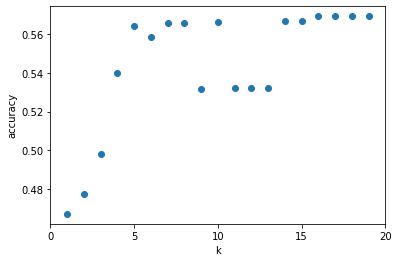

In [ ]:
find_k(X, y, 1, 20)

En el gráfico se observa como k = 16, 17, 18, 19 son los valores que mejor presición tienen, por lo tanto elegimos uno de esos valores para la cantidad de n_neighbors, en nuestro caso eligiremos 16.

In [ ]:
#KNN as a feature engineering
knn_2 = KNeighborsClassifier(n_neighbors= 16, metric='manhattan')
knn_2.fit(X, y)
predic = pd.DataFrame(data = knn_2.predict_proba(X))
predic.columns = ['1_damage_probability', '2_damage_probability', '3_damage_probability']
predic

,1_damage_probability,2_damage_probability,3_damage_probability
0,0.0625,0.6875,0.2500
1,0.1250,0.5625,0.3125
2,0.0625,0.6875,0.2500
3,0.0625,0.6875,0.2500
4,0.1250,0.4375,0.4375
...,...,...,...
260596,0.2500,0.5000,0.2500
260597,0.0625,0.6875,0.2500
260598,0.0000,0.5000,0.5000
260599,0.0625,0.6875,0.2500


In [ ]:
df_tot['3_damage_probability_with_floors_dependency'] = predic['3_damage_probability'] 
df_tot

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used,3_damage_probability_with_glb,3_damage_probability_with_floors_dependency
0,802906,3,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.046154,0.080645,0.011407,1,0,0.166667,0.200000,0.033333,2,0.857143,0.2500
1,28830,2,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,56,3.500000,0.072727,0.166667,0.021456,1,0,0.125000,0.142857,0.017857,1,0.142857,0.3125
2,94947,3,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,25,2.500000,0.045455,0.119048,0.009579,1,0,0.200000,0.200000,0.040000,1,0.857143,0.2500
3,590882,2,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.054545,0.119048,0.011494,0,0,0.166667,0.200000,0.033333,3,0.214286,0.2500
4,201944,3,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,72,3.000000,0.061538,0.145161,0.027376,0,0,0.125000,0.111111,0.013889,1,0.357143,0.4375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,2,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,18,3.000000,0.038710,0.034483,0.006780,0,0,0.166667,0.333333,0.055556,1,0.071429,0.2500
260597,669485,3,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.060000,0.156250,0.011538,1,0,0.166667,0.200000,0.033333,1,1.000000,0.2500
260598,602512,3,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.038710,0.080460,0.015819,1,0,0.166667,0.142857,0.023810,1,0.928571,0.5000
260599,151409,2,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,84,3.000000,0.127273,0.142857,0.032184,1,0,0.071429,0.166667,0.011905,1,0.000000,0.2500


####Features con families

In [ ]:
predictors = ['count_fams_per_area', 'count_fams_per_height', 'count_fams_per_volume']
outcome = 'damage_grade'
X = df_tot[predictors]
y = df_tot[outcome]

Probamos distintos valores de k para ver cual es el que mayor presición logra

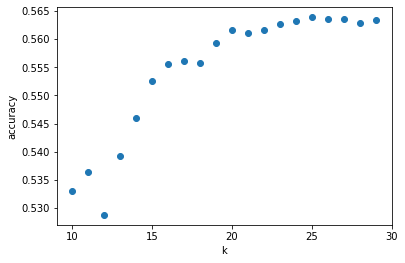

In [ ]:
find_k(X, y, 10, 30)

En el gráfico se observa como k = 25 es el valor que mejor presición tiene, por lo tanto usamos esa cantidad de n_neighbors

In [ ]:
#KNN as a feature engineering
knn_3 = KNeighborsClassifier(n_neighbors= 25, metric='manhattan')
knn_3.fit(X, y)
predic = pd.DataFrame(data = knn_3.predict_proba(X))
predic.columns = ['1_damage_probability', '2_damage_probability', '3_damage_probability']
predic

,1_damage_probability,2_damage_probability,3_damage_probability
0,0.08,0.76,0.16
1,0.08,0.52,0.40
2,0.00,0.60,0.40
3,0.08,0.76,0.16
4,0.00,0.52,0.48
...,...,...,...
260596,0.28,0.52,0.20
260597,0.08,0.76,0.16
260598,0.04,0.60,0.36
260599,0.24,0.40,0.36


In [ ]:
df_tot['3_damage_probability_with_families'] = predic['3_damage_probability'] 
df_tot

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used,3_damage_probability_with_glb,3_damage_probability_with_floors_dependency,3_damage_probability_with_families
0,802906,3,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.046154,0.080645,0.011407,1,0,0.166667,0.200000,0.033333,2,0.857143,0.2500,0.16
1,28830,2,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,56,3.500000,0.072727,0.166667,0.021456,1,0,0.125000,0.142857,0.017857,1,0.142857,0.3125,0.40
2,94947,3,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,25,2.500000,0.045455,0.119048,0.009579,1,0,0.200000,0.200000,0.040000,1,0.857143,0.2500,0.40
3,590882,2,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.054545,0.119048,0.011494,0,0,0.166667,0.200000,0.033333,3,0.214286,0.2500,0.16
4,201944,3,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,72,3.000000,0.061538,0.145161,0.027376,0,0,0.125000,0.111111,0.013889,1,0.357143,0.4375,0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,2,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,18,3.000000,0.038710,0.034483,0.006780,0,0,0.166667,0.333333,0.055556,1,0.071429,0.2500,0.20
260597,669485,3,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.060000,0.156250,0.011538,1,0,0.166667,0.200000,0.033333,1,1.000000,0.2500,0.16
260598,602512,3,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.038710,0.080460,0.015819,1,0,0.166667,0.142857,0.023810,1,0.928571,0.5000,0.36
260599,151409,2,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,84,3.000000,0.127273,0.142857,0.032184,1,0,0.071429,0.166667,0.011905,1,0.000000,0.2500,0.36


###Interacción entre features categóricas 

In [ ]:
df_tot['floor_type_sum'] = df_tot.ground_floor_type + df_tot.other_floor_type
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['floor_type_sum'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['floor_type_sum'] =  df_tot['floor_type_sum'].map(Mean_encoded_subject)

In [ ]:
df_tot['surface_condition_floor_type_sum'] = df_tot.ground_floor_type + df_tot.other_floor_type + df_tot.land_surface_condition
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['surface_condition_floor_type_sum'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['surface_condition_floor_type_sum'] =  df_tot['surface_condition_floor_type_sum'].map(Mean_encoded_subject)

In [ ]:
df_tot['roof_foundation_sum'] = df_tot.roof_type + df_tot.foundation_type
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['roof_foundation_sum'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['roof_foundation_sum'] =  df_tot['roof_foundation_sum'].map(Mean_encoded_subject)

In [ ]:
df_tot['plan_other_floor_sum'] = df_tot.plan_configuration + df_tot.other_floor_type
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['plan_other_floor_sum'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['plan_other_floor_sum'] =  df_tot['plan_other_floor_sum'].map(Mean_encoded_subject)

###Mean Encoding para features categoricas

####Feature 'land_surface_condition'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['land_surface_condition'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['land_surface_condition'] =  df_tot['land_surface_condition'].map(Mean_encoded_subject)

####Feature 'foundation_type'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['foundation_type'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['foundation_type'] =  df_tot['foundation_type'].map(Mean_encoded_subject)

####Feature 'roof_type'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['roof_type'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['roof_type'] =  df_tot['roof_type'].map(Mean_encoded_subject)

####Feature 'ground_floor_type'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['ground_floor_type'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['ground_floor_type'] =  df_tot['ground_floor_type'].map(Mean_encoded_subject)

####Feature 'other_floor_type'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['other_floor_type'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['other_floor_type'] =  df_tot['other_floor_type'].map(Mean_encoded_subject)

####Feature 'position'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['position'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['position'] =  df_tot['position'].map(Mean_encoded_subject)

####Feature 'plan_configuration'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['plan_configuration'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['plan_configuration'] =  df_tot['plan_configuration'].map(Mean_encoded_subject)

####Feature 'legal_ownership_status'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = df_tot.groupby(['legal_ownership_status'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
df_tot['legal_ownership_status'] =  df_tot['legal_ownership_status'].map(Mean_encoded_subject)

In [ ]:
df_tot

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used,3_damage_probability_with_glb,3_damage_probability_with_floors_dependency,3_damage_probability_with_families,floor_type_sum,surface_condition_floor_type_sum,roof_foundation_sum,plan_other_floor_sum
0,802906,3,6,487,12198,2,30,6,5,0.082364,0.028787,0.048742,0.014913,0.017165,0.091524,0.070412,1,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.046154,0.080645,0.011407,1,0,0.166667,0.200000,0.033333,2,0.857143,0.2500,0.16,0.009961,0.010848,0.025701,0.016222
1,28830,2,8,900,2812,2,10,8,7,0.044372,0.028787,0.048742,0.118181,0.017165,0.062828,0.070412,0,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,56,3.500000,0.072727,0.166667,0.021456,1,0,0.125000,0.142857,0.017857,1,0.142857,0.3125,0.40,0.032799,0.011662,0.025701,0.016222
2,94947,3,21,363,8973,2,10,5,5,0.082364,0.028787,0.048742,0.014913,0.050060,0.091524,0.070412,0,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,25,2.500000,0.045455,0.119048,0.009579,1,0,0.200000,0.200000,0.040000,1,0.857143,0.2500,0.40,0.017309,0.020222,0.025701,0.046112
3,590882,2,22,418,10694,2,10,6,5,0.082364,0.028787,0.048742,0.014913,0.050060,0.062828,0.070412,0,1,0,0,0,0,1,1,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.054545,0.119048,0.011494,0,0,0.166667,0.200000,0.033333,3,0.214286,0.2500,0.16,0.017309,0.020222,0.025701,0.046112
4,201944,3,11,131,1488,3,30,8,9,0.082364,0.028787,0.048742,0.014913,0.050060,0.062828,0.070412,1,0,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,72,3.000000,0.061538,0.145161,0.027376,0,0,0.125000,0.111111,0.013889,1,0.357143,0.4375,0.48,0.017309,0.020222,0.025701,0.046112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,2,25,1335,1621,1,55,6,3,0.039209,0.028787,0.048742,0.014913,0.214868,0.062828,0.127723,0,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,18,3.000000,0.038710,0.034483,0.006780,0,0,0.166667,0.333333,0.055556,1,0.071429,0.2500,0.20,0.032030,0.017015,0.025701,0.230868
260597,669485,3,17,715,2060,2,0,6,5,0.082364,0.028787,0.048742,0.014913,0.017165,0.062828,0.070412,0,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.060000,0.156250,0.011538,1,0,0.166667,0.200000,0.033333,1,1.000000,0.2500,0.16,0.009961,0.010848,0.025701,0.016222
260598,602512,3,17,51,8163,3,55,6,7,0.082364,0.028787,0.040893,0.014913,0.017165,0.062828,0.070412,0,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.038710,0.080460,0.015819,1,0,0.166667,0.142857,0.023810,1,0.928571,0.5000,0.36,0.009961,0.010848,0.014107,0.016222
260599,151409,2,26,39,1851,2,10,14,6,0.082364,0.028787,0.505778,0.544098,0.502328,0.185740,0.070412,0,0,0,0,0,1,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,84,3.000

##Feature Engineering para el test_sample

###Interaccion entre features numericas

In [ ]:
test_values['volume_percentage'] = test_values.area_percentage * test_values.height_percentage

In [ ]:
test_values['floor_height'] = test_values.height_percentage / test_values.count_floors_pre_eq

In [ ]:
#Busco darle un peso a la edad del edificio y asi darle un puntaje entre 0 y 1
#Si la edad -> 0, el puntaje -> 1
#Si la edad -> inf, el puntaje -> 0
test_values['age_area_relation'] = test_values.area_percentage / (test_values.age + test_values.area_percentage.max())

In [ ]:
#Busco darle un peso a la edad del edificio y asi darle un puntaje entre 0 y 1
#Si la edad -> 0, el puntaje -> 1
#Si la edad -> inf, el puntaje -> 0
test_values['age_height_relation'] = test_values.height_percentage / (test_values.age + test_values.height_percentage.max())

In [ ]:
#Busco darle un peso a la edad del edificio y asi darle un puntaje entre 0 y 1
#Si la edad -> 0, el puntaje -> 1
#Si la edad -> inf, el puntaje -> 0
test_values['age_volume_relation'] = test_values.volume_percentage / (test_values.age + test_values.volume_percentage.max())

In [ ]:
#Las regiones (level 1) con mas de 6000 edificios con destrucción moderada o
# total registrados son: 6,17,10,8,7,21,26,20,4,27
ser_aux =(test_values.geo_level_1_id == 6)|(test_values.geo_level_1_id == 17)|(test_values.geo_level_1_id == 10)\
          |(test_values.geo_level_1_id == 8)|(test_values.geo_level_1_id == 7)|(test_values.geo_level_1_id == 21)\
          |(test_values.geo_level_1_id == 26)|(test_values.geo_level_1_id == 20)|(test_values.geo_level_1_id == 4)\
          |(test_values.geo_level_1_id == 27)
test_values['is_from_most_affected_regions'] = ser_aux.replace({True: 1, False: 0})

In [ ]:
#Los rubros mas afectados son: agriculture,hotel,rental,institution
ser_aux2 = (test_values.has_secondary_use_agriculture==1)|(test_values.has_secondary_use_hotel==1)|\
            (test_values.has_secondary_use_rental==1)|(test_values.has_secondary_use_institution==1)
test_values['is_from_most_affected_usages'] = ser_aux2.replace({True: 1, False: 0})

In [ ]:
test_values['count_fams_per_area'] = test_values.count_families / test_values.area_percentage

In [ ]:
test_values['count_fams_per_height'] = test_values.count_families / test_values.height_percentage

In [ ]:
test_values['count_fams_per_volume'] = test_values.count_families / test_values.volume_percentage

In [ ]:
test_values['count_materials_used'] = test_values.has_superstructure_adobe_mud+test_values.has_superstructure_bamboo+\
                                  test_values.has_superstructure_cement_mortar_brick+test_values.has_superstructure_cement_mortar_stone+\
                                  test_values.has_superstructure_mud_mortar_brick+test_values.has_superstructure_mud_mortar_stone+\
                                  test_values.has_superstructure_other+test_values.has_superstructure_rc_engineered+\
                                  test_values.has_superstructure_rc_non_engineered+test_values.has_superstructure_stone_flag+\
                                  test_values.has_superstructure_timber\


In [ ]:
test_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.000000,0.062500,0.115385,0.029412,1,0,0.142857,0.166667,0.023810,1
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,65,2.500000,0.111111,0.087719,0.045359,1,1,0.076923,0.200000,0.015385,1
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,20,2.500000,0.041237,0.135135,0.014154,0,0,0.250000,0.200000,0.050000,1
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,57,3.000000,0.206522,0.093750,0.040483,1,1,0.105263,0.666667,0.035088,1
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,56,2.333333,0.074766,0.148936,0.039353,1,0,0.125000,0.142857,0.017857,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,120,2.000000,0.123457,0.058824,0.081191,1,1,0.050000,0.166667,0.008333,2
86864,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.051282,0.122807,0.029309,1,0,0.166667,0.142857,0.023810,3
86865,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,9,3.000000,0.021127,0.036585,0.006173,0,0,0.333333,0.333333,0.111111,2
86866,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0,45,2.500000,0.092784,0.135135,0.031847,1,0,0.111111,0.200000,0.022222,2


###Features con KNN

####Features con geo_level

In [ ]:
predictors = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
X = test_values[predictors]

In [ ]:
#KNN as a feature engineering
predic = pd.DataFrame(data = knn_1.predict_proba(X))
predic.columns = ['1_damage_probability', '2_damage_probability', '3_damage_probability']
test_values['3_damage_probability_with_glb'] = predic['3_damage_probability'] 
test_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used,3_damage_probability_with_glb
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.000000,0.062500,0.115385,0.029412,1,0,0.142857,0.166667,0.023810,1,0.714286
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,65,2.500000,0.111111,0.087719,0.045359,1,1,0.076923,0.200000,0.015385,1,0.000000
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,20,2.500000,0.041237,0.135135,0.014154,0,0,0.250000,0.200000,0.050000,1,0.285714
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,57,3.000000,0.206522,0.093750,0.040483,1,1,0.105263,0.666667,0.035088,1,0.000000
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,56,2.333333,0.074766,0.148936,0.039353,1,0,0.125000,0.142857,0.017857,1,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,120,2.000000,0.123457,0.058824,0.081191,1,1,0.050000,0.166667,0.008333,2,0.000000
86864,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.051282,0.122807,0.029309,1,0,0.166667,0.142857,0.023810,3,0.714286
86865,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,9,3.000000,0.021127,0.036585,0.006173,0,0,0.333333,0.333333,0.111111,2,0.071429
86866,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0,45,2.500000,0.092784,0.135135,0.031847,1,0,0.111111,0.200000,0.022222,2,0.285714


####Features con floors


In [ ]:
predictors = ['floor_height', 'count_floors_pre_eq']
X = test_values[predictors]

In [ ]:
#KNN as a feature engineering
predic = pd.DataFrame(data = knn_2.predict_proba(X))
predic.columns = ['1_damage_probability', '2_damage_probability', '3_damage_probability']
predic

,1_damage_probability,2_damage_probability,3_damage_probability
0,0.0000,0.5625,0.4375
1,0.0625,0.6875,0.2500
2,0.0625,0.6875,0.2500
3,0.2500,0.5000,0.2500
4,0.0000,0.5000,0.5000
...,...,...,...
86863,0.0000,0.5625,0.4375
86864,0.0000,0.5000,0.5000
86865,0.2500,0.5000,0.2500
86866,0.0625,0.6875,0.2500


In [ ]:
test_values['3_damage_probability_with_floors_dependency'] = predic['3_damage_probability'] 
test_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used,3_damage_probability_with_glb,3_damage_probability_with_floors_dependency
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.000000,0.062500,0.115385,0.029412,1,0,0.142857,0.166667,0.023810,1,0.714286,0.4375
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,65,2.500000,0.111111,0.087719,0.045359,1,1,0.076923,0.200000,0.015385,1,0.000000,0.2500
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,20,2.500000,0.041237,0.135135,0.014154,0,0,0.250000,0.200000,0.050000,1,0.285714,0.2500
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,57,3.000000,0.206522,0.093750,0.040483,1,1,0.105263,0.666667,0.035088,1,0.000000,0.2500
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,56,2.333333,0.074766,0.148936,0.039353,1,0,0.125000,0.142857,0.017857,1,0.857143,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,120,2.000000,0.123457,0.058824,0.081191,1,1,0.050000,0.166667,0.008333,2,0.000000,0.4375
86864,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.051282,0.122807,0.029309,1,0,0.166667,0.142857,0.023810,3,0.714286,0.5000
86865,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,9,3.000000,0.021127,0.036585,0.006173,0,0,0.333333,0.333333,0.111111,2,0.071429,0.2500
86866,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0,45,2.500000,0.092784,0.135135,0.031847,1,0,0.111111,0.200000,0.022222,2,0.285714,0.2500


####Features con families

In [ ]:
predictors = ['count_fams_per_area', 'count_fams_per_height', 'count_fams_per_volume']
X = test_values[predictors]

In [ ]:
#KNN as a feature engineering
predic = pd.DataFrame(data = knn_3.predict_proba(X))
predic.columns = ['1_damage_probability', '2_damage_probability', '3_damage_probability']
predic

,1_damage_probability,2_damage_probability,3_damage_probability
0,0.04,0.64,0.32
1,0.08,0.76,0.16
2,0.12,0.36,0.52
3,0.48,0.44,0.08
4,0.08,0.52,0.40
...,...,...,...
86863,0.12,0.68,0.20
86864,0.04,0.60,0.36
86865,0.20,0.52,0.28
86866,0.00,0.80,0.20


In [ ]:
test_values['3_damage_probability_with_families'] = predic['3_damage_probability'] 
test_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used,3_damage_probability_with_glb,3_damage_probability_with_floors_dependency,3_damage_probability_with_families
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.000000,0.062500,0.115385,0.029412,1,0,0.142857,0.166667,0.023810,1,0.714286,0.4375,0.32
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,65,2.500000,0.111111,0.087719,0.045359,1,1,0.076923,0.200000,0.015385,1,0.000000,0.2500,0.16
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,20,2.500000,0.041237,0.135135,0.014154,0,0,0.250000,0.200000,0.050000,1,0.285714,0.2500,0.52
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0,57,3.000000,0.206522,0.093750,0.040483,1,1,0.105263,0.666667,0.035088,1,0.000000,0.2500,0.08
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,56,2.333333,0.074766,0.148936,0.039353,1,0,0.125000,0.142857,0.017857,1,0.857143,0.5000,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0,120,2.000000,0.123457,0.058824,0.081191,1,1,0.050000,0.166667,0.008333,2,0.000000,0.4375,0.20
86864,663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.051282,0.122807,0.029309,1,0,0.166667,0.142857,0.023810,3,0.714286,0.5000,0.36
86865,1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,9,3.000000,0.021127,0.036585,0.006173,0,0,0.333333,0.333333,0.111111,2,0.071429,0.2500,0.28
86866,442785,6,1041,912,2,5,9,5,t,r,n,f,q,s,d,1,1,0,0,0,0,0,0,0,0,0,a,1,0,0,0,0,0,0,0,0,0,0,0,45,2.500000,0.092784,0.135135,0.031847,1,0,0.111111,0.200000,0.022222,2,0.285714,0.2500,0.20


###Interacción entre features categóricas 

In [ ]:
test_values['floor_type_sum'] = test_values.ground_floor_type + test_values.other_floor_type
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['floor_type_sum'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['floor_type_sum'] =  test_values['floor_type_sum'].map(Mean_encoded_subject)

In [ ]:
test_values['surface_condition_floor_type_sum'] = test_values.ground_floor_type + test_values.other_floor_type + test_values.land_surface_condition
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['surface_condition_floor_type_sum'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['surface_condition_floor_type_sum'] =  test_values['surface_condition_floor_type_sum'].map(Mean_encoded_subject)

In [ ]:
test_values['roof_foundation_sum'] = test_values.roof_type + test_values.foundation_type
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['roof_foundation_sum'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['roof_foundation_sum'] =  test_values['roof_foundation_sum'].map(Mean_encoded_subject)

In [ ]:
test_values['plan_other_floor_sum'] = test_values.plan_configuration + test_values.other_floor_type
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['plan_other_floor_sum'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['plan_other_floor_sum'] =  test_values['plan_other_floor_sum'].map(Mean_encoded_subject)

###Mean Encoding para features categoricas

####Feature 'land_surface_condition'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['land_surface_condition'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['land_surface_condition'] =  test_values['land_surface_condition'].map(Mean_encoded_subject)

####Feature 'foundation_type'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['foundation_type'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['foundation_type'] =  test_values['foundation_type'].map(Mean_encoded_subject)

####Feature 'roof_type'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['roof_type'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['roof_type'] =  test_values['roof_type'].map(Mean_encoded_subject)

####Feature 'ground_floor_type'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['ground_floor_type'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['ground_floor_type'] =  test_values['ground_floor_type'].map(Mean_encoded_subject)

####Feature 'other_floor_type'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['other_floor_type'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['other_floor_type'] =  test_values['other_floor_type'].map(Mean_encoded_subject)

####Feature 'position'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['position'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['position'] =  test_values['position'].map(Mean_encoded_subject)

####Feature 'plan_configuration'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['plan_configuration'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['plan_configuration'] =  test_values['plan_configuration'].map(Mean_encoded_subject)

####Feature 'legal_ownership_status'

In [ ]:
#Mean enconding usando el feature 'has_superstructure_cement_mortar_brick' como target
#ya que es el mat con mayor eficiencia (ver TP1)
Mean_encoded_subject = test_values.groupby(['legal_ownership_status'])['has_superstructure_cement_mortar_brick'].mean().to_dict()
test_values['legal_ownership_status'] =  test_values['legal_ownership_status'].map(Mean_encoded_subject)

In [ ]:
test_values

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used,3_damage_probability_with_glb,3_damage_probability_with_floors_dependency,3_damage_probability_with_families,floor_type_sum,surface_condition_floor_type_sum,roof_foundation_sum,plan_other_floor_sum
0,300051,17,596,11307,3,20,7,6,0.080313,0.027918,0.046865,0.015220,0.017726,0.060647,0.068693,0,1,0,0,0,0,0,0,0,0,0,0.070925,1,0,0,0,0,0,0,0,0,0,0,0,42,2.000000,0.062500,0.115385,0.029412,1,0,0.142857,0.166667,0.023810,1,0.714286,0.4375,0.32,0.010067,0.010926,0.024847,0.016683
1,99355,6,141,11987,2,25,13,5,0.080313,0.027918,0.046865,0.015220,0.017726,0.060647,0.068693,0,1,0,0,0,0,0,0,0,0,0,0.070925,1,1,1,0,0,0,0,0,0,0,0,0,65,2.500000,0.111111,0.087719,0.045359,1,1,0.076923,0.200000,0.015385,1,0.000000,0.2500,0.16,0.010067,0.010926,0.024847,0.016683
2,890251,22,19,10044,2,5,4,5,0.080313,0.027918,0.046865,0.015220,0.017726,0.060647,0.068693,0,1,0,0,0,0,0,0,0,0,0,0.070925,1,0,0,0,0,0,0,0,0,0,0,0,20,2.500000,0.041237,0.135135,0.014154,0,0,0.250000,0.200000,0.050000,1,0.285714,0.2500,0.52,0.010067,0.010926,0.024847,0.016683
3,745817,26,39,633,1,0,19,3,0.080313,0.027918,0.487976,0.532195,0.208126,0.090934,0.068693,0,0,0,0,0,1,0,0,0,0,0,0.070925,2,1,0,0,1,0,0,0,0,0,0,0,57,3.000000,0.206522,0.093750,0.040483,1,1,0.105263,0.666667,0.035088,1,0.000000,0.2500,0.08,0.667341,0.671091,0.513285,0.197635
4,421793,17,289,7970,3,15,8,7,0.080313,0.027918,0.044813,0.015220,0.017726,0.090934,0.068693,0,1,0,0,0,0,0,0,0,0,0,0.070925,1,0,0,0,0,0,0,0,0,0,0,0,56,2.333333,0.074766,0.148936,0.039353,1,0,0.125000,0.142857,0.017857,1,0.857143,0.5000,0.40,0.010067,0.010926,0.014260,0.016683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,310028,4,605,3623,3,70,20,6,0.080313,0.027918,0.044813,0.015220,0.017726,0.090934,0.068693,0,1,0,0,0,0,1,0,0,0,0,0.044084,1,1,1,0,0,0,0,0,0,0,0,0,120,2.000000,0.123457,0.058824,0.081191,1,1,0.050000,0.166667,0.008333,2,0.000000,0.4375,0.20,0.010067,0.010926,0.014260,0.016683
86864,663567,10,1407,11907,3,25,6,7,0.039882,0.027918,0.046865,0.015220,0.017726,0.060647,0.068693,1,1,1,0,0,0,0,0,0,0,0,0.070925,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.051282,0.122807,0.029309,1,0,0.166667,0.142857,0.023810,3,0.714286,0.5000,0.36,0.010067,0.005127,0.024847,0.016683
86865,1049160,22,1136,7712,1,50,3,3,0.080313,0.027918,0.046865,0.015220,0.208126,0.060647,0.068693,0,1,0,0,0,0,1,0,0,0,0,0.070925,1,0,0,0,0,0,0,0,0,0,0,0,9,3.000000,0.021127,0.036585,0.006173,0,0,0.333333,0.333333,0.111111,2,0.071429,0.2500,0.28,0.034895,0.039270,0.024847,0.197635
86866,442785,6,1041,912,2,5,9,5,0.080313,0.027918,0.046865,0.015220,0.017726,0.060647,0.068693,1,1,0,0,0,0,0,0,0,0,0,0.217827,1,0,0,0,0,0,0,0,0,0,0,0,45,2.500000,0.092784,0.135135,0.031847,1,0,0

##Spliteo el set de test y de training

In [ ]:
X_train = df_tot.copy()
X_train.drop(columns=['damage_grade','building_id'], inplace=True)
X_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used,3_damage_probability_with_glb,3_damage_probability_with_floors_dependency,3_damage_probability_with_families,floor_type_sum,surface_condition_floor_type_sum,roof_foundation_sum,plan_other_floor_sum
0,6,487,12198,2,30,6,5,0.082364,0.028787,0.048742,0.014913,0.017165,0.091524,0.070412,1,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.046154,0.080645,0.011407,1,0,0.166667,0.200000,0.033333,2,0.857143,0.2500,0.16,0.009961,0.010848,0.025701,0.016222
1,8,900,2812,2,10,8,7,0.044372,0.028787,0.048742,0.118181,0.017165,0.062828,0.070412,0,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,56,3.500000,0.072727,0.166667,0.021456,1,0,0.125000,0.142857,0.017857,1,0.142857,0.3125,0.40,0.032799,0.011662,0.025701,0.016222
2,21,363,8973,2,10,5,5,0.082364,0.028787,0.048742,0.014913,0.050060,0.091524,0.070412,0,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,25,2.500000,0.045455,0.119048,0.009579,1,0,0.200000,0.200000,0.040000,1,0.857143,0.2500,0.40,0.017309,0.020222,0.025701,0.046112
3,22,418,10694,2,10,6,5,0.082364,0.028787,0.048742,0.014913,0.050060,0.062828,0.070412,0,1,0,0,0,0,1,1,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.054545,0.119048,0.011494,0,0,0.166667,0.200000,0.033333,3,0.214286,0.2500,0.16,0.017309,0.020222,0.025701,0.046112
4,11,131,1488,3,30,8,9,0.082364,0.028787,0.048742,0.014913,0.050060,0.062828,0.070412,1,0,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,72,3.000000,0.061538,0.145161,0.027376,0,0,0.125000,0.111111,0.013889,1,0.357143,0.4375,0.48,0.017309,0.020222,0.025701,0.046112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,25,1335,1621,1,55,6,3,0.039209,0.028787,0.048742,0.014913,0.214868,0.062828,0.127723,0,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,18,3.000000,0.038710,0.034483,0.006780,0,0,0.166667,0.333333,0.055556,1,0.071429,0.2500,0.20,0.032030,0.017015,0.025701,0.230868
260597,17,715,2060,2,0,6,5,0.082364,0.028787,0.048742,0.014913,0.017165,0.062828,0.070412,0,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,30,2.500000,0.060000,0.156250,0.011538,1,0,0.166667,0.200000,0.033333,1,1.000000,0.2500,0.16,0.009961,0.010848,0.025701,0.016222
260598,17,51,8163,3,55,6,7,0.082364,0.028787,0.040893,0.014913,0.017165,0.062828,0.070412,0,1,0,0,0,0,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.038710,0.080460,0.015819,1,0,0.166667,0.142857,0.023810,1,0.928571,0.5000,0.36,0.009961,0.010848,0.014107,0.016222
260599,26,39,1851,2,10,14,6,0.082364,0.028787,0.505778,0.544098,0.502328,0.185740,0.070412,0,0,0,0,0,1,0,0,0,0,0,0.072551,1,0,0,0,0,0,0,0,0,0,0,0,84,3.000000,0.127273,0.142857,0.032184,1,0,0.071429,0.166667,0.011905,1,0.000000,0.2500,0.36,0.493890,0.497201,0.536488,

In [ ]:
y_train = df_tot.damage_grade
X_test = test_values.copy()
X_test.drop(columns='building_id', inplace=True)
X_test

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,volume_percentage,floor_height,age_area_relation,age_height_relation,age_volume_relation,is_from_most_affected_regions,is_from_most_affected_usages,count_fams_per_area,count_fams_per_height,count_fams_per_volume,count_materials_used,3_damage_probability_with_glb,3_damage_probability_with_floors_dependency,3_damage_probability_with_families,floor_type_sum,surface_condition_floor_type_sum,roof_foundation_sum,plan_other_floor_sum
0,17,596,11307,3,20,7,6,0.080313,0.027918,0.046865,0.015220,0.017726,0.060647,0.068693,0,1,0,0,0,0,0,0,0,0,0,0.070925,1,0,0,0,0,0,0,0,0,0,0,0,42,2.000000,0.062500,0.115385,0.029412,1,0,0.142857,0.166667,0.023810,1,0.714286,0.4375,0.32,0.010067,0.010926,0.024847,0.016683
1,6,141,11987,2,25,13,5,0.080313,0.027918,0.046865,0.015220,0.017726,0.060647,0.068693,0,1,0,0,0,0,0,0,0,0,0,0.070925,1,1,1,0,0,0,0,0,0,0,0,0,65,2.500000,0.111111,0.087719,0.045359,1,1,0.076923,0.200000,0.015385,1,0.000000,0.2500,0.16,0.010067,0.010926,0.024847,0.016683
2,22,19,10044,2,5,4,5,0.080313,0.027918,0.046865,0.015220,0.017726,0.060647,0.068693,0,1,0,0,0,0,0,0,0,0,0,0.070925,1,0,0,0,0,0,0,0,0,0,0,0,20,2.500000,0.041237,0.135135,0.014154,0,0,0.250000,0.200000,0.050000,1,0.285714,0.2500,0.52,0.010067,0.010926,0.024847,0.016683
3,26,39,633,1,0,19,3,0.080313,0.027918,0.487976,0.532195,0.208126,0.090934,0.068693,0,0,0,0,0,1,0,0,0,0,0,0.070925,2,1,0,0,1,0,0,0,0,0,0,0,57,3.000000,0.206522,0.093750,0.040483,1,1,0.105263,0.666667,0.035088,1,0.000000,0.2500,0.08,0.667341,0.671091,0.513285,0.197635
4,17,289,7970,3,15,8,7,0.080313,0.027918,0.044813,0.015220,0.017726,0.090934,0.068693,0,1,0,0,0,0,0,0,0,0,0,0.070925,1,0,0,0,0,0,0,0,0,0,0,0,56,2.333333,0.074766,0.148936,0.039353,1,0,0.125000,0.142857,0.017857,1,0.857143,0.5000,0.40,0.010067,0.010926,0.014260,0.016683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,4,605,3623,3,70,20,6,0.080313,0.027918,0.044813,0.015220,0.017726,0.090934,0.068693,0,1,0,0,0,0,1,0,0,0,0,0.044084,1,1,1,0,0,0,0,0,0,0,0,0,120,2.000000,0.123457,0.058824,0.081191,1,1,0.050000,0.166667,0.008333,2,0.000000,0.4375,0.20,0.010067,0.010926,0.014260,0.016683
86864,10,1407,11907,3,25,6,7,0.039882,0.027918,0.046865,0.015220,0.017726,0.060647,0.068693,1,1,1,0,0,0,0,0,0,0,0,0.070925,1,0,0,0,0,0,0,0,0,0,0,0,42,2.333333,0.051282,0.122807,0.029309,1,0,0.166667,0.142857,0.023810,3,0.714286,0.5000,0.36,0.010067,0.005127,0.024847,0.016683
86865,22,1136,7712,1,50,3,3,0.080313,0.027918,0.046865,0.015220,0.208126,0.060647,0.068693,0,1,0,0,0,0,1,0,0,0,0,0.070925,1,0,0,0,0,0,0,0,0,0,0,0,9,3.000000,0.021127,0.036585,0.006173,0,0,0.333333,0.333333,0.111111,2,0.071429,0.2500,0.28,0.034895,0.039270,0.024847,0.197635
86866,6,1041,912,2,5,9,5,0.080313,0.027918,0.046865,0.015220,0.017726,0.060647,0.068693,1,1,0,0,0,0,0,0,0,0,0,0.217827,1,0,0,0,0,0,0,0,0,0,0,0,45,2.500000,0.092784,0.135135,0.031847,1,0,0.111111,0.200000,0.022222,2,0.285714,0.2500,0.20,0.010067,0.010926,0.024847,0.0

##XGBoost

### Ensamble

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [ ]:
models = list()
models.append(('xgb', xgb.XGBClassifier(objective ='multi:softprob', 
                colsample_bytree = 0.7133263189215068, learning_rate = 0.33289715930447994,
                max_depth = 7, alpha = 1.8984710608475652, n_estimators = 220)))
models.append(('Lgbm', LGBMClassifier(max_depth=5, n_estimators=220, objective='multiclass', colsample_bytree=0.8835040235712495)))

modelo1 = KNeighborsClassifier(n_neighbors=100, algorithm='kd_tree')
modelo = StackingClassifier(estimators=models, final_estimator=modelo1, cv=10)

### Training

In [ ]:
modelo.fit(X_train,y_train)

StackingClassifier(cv=10,
                   estimators=[('xgb',
                                XGBClassifier(alpha=1.8984710608475652,
                                              base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.7133263189215068,
                                              gamma=0,
                                              learning_rate=0.33289715930447994,
                                              max_delta_step=0, max_depth=7,
                                              min_child_weight=1, missing=None,
                                              n_estimators=220, n_jobs=1,
                                              nthread=None,
                                              objective='multi:s...
                                               objective='multiclass',
 

### Prediction

In [ ]:
preds = modelo.predict(X_test)

In [ ]:
my_submission = submission_format.copy()
my_submission['damage_grade'] = preds

In [ ]:
my_submission.to_csv('submission.csv')

##Guardo el modelo entrenado

In [ ]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(modelo, open(filename, 'wb'))

##Levanto el modelo ya entrenado

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))